In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from utility import analysis_parameters as ap, util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

colors=ap.COLORS

In [2]:
region="TWP"
m="SHiELD"
thres="cl_5e-7kgm-3"

In [5]:
# iwpmask = xr.open_dataset("/scratch/b/b380883/temp/TWP_3D_UM_iwp-mask.nc").clivi
# iwpmask[322].plot.pcolormesh()
# len(iwpmask[322].values[iwpmask[322].values>=1]), iwpmask[322].where(iwpmask[322]>=1).count().values, iwpmask[322].sum().values, iwpmask[322].count().values, iwpmask[322].values.flatten().shape

In [5]:
if m=="UM":
    chunks={"time":64,"latitude":32,"longitude":32} # lat lon
    cl = xr.open_dataset(ap.get_file(m,region+"_3D",thres), 
                              chunks=chunks).cl[:,1:]
elif m=="SCREAM":
    chunks={"time":64,"ncol":256} # ncol
    cl = xr.open_dataset(ap.get_file(m,region+"_3D",thres), 
                              chunks=chunks).cl[:,1:]
elif m=="GEOS":
    chunks={"Xdim":1000} # Xdim
    cl = xr.open_dataset(ap.get_file(m,region+"_3D",thres), 
                              chunks=chunks).cl[::3,1:]
elif m=="SHiELD":
    chunks={"time":120, "Xdim":1000} # Xdim
    cl = xr.open_dataset(ap.get_file(m,region+"_3D",thres), 
                              chunks=chunks).cl[::,1:]
elif m=="ICON":
    chunks={"time":210//2, "cell":500} # cell
    cl = xr.open_dataset(ap.get_file(m,region+"_3D",thres), 
                              chunks=chunks).cl[:,1:,::2]
cl

<xarray.DataArray 'cl' (time: 240, pfull_ref: 78, Xdim: 110626)>
dask.array<getitem, shape=(240, 78, 110626), dtype=float32, chunksize=(120, 78, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-29
    lon        (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat        (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
  * pfull_ref  (pfull_ref) float32 8.301 12.45 16.74 21.04 ... 989.5 994.3 998.3
Dimensions without coordinates: Xdim
Attributes:
    standard_name:  air_pressure
    long_name:      non-hydrostatic pressure
    units:          frac
    CDI_grid_type:  unstructured
    cell_methods:   time: point
    origin:         pressure

In [6]:
iwp = xr.open_dataset(ap.get_file(m,region=region,
                                  var="clivi"), 
                      chunks=chunks).clivi.sel(time=cl.time, method="nearest").values[:,np.newaxis]
iwp.shape

[########################################] | 100% Completed |  3.0s


(240, 1, 110626)

In [7]:
m, iwp.shape, cl.shape

('SHiELD', (240, 1, 110626), (240, 78, 110626))

In [8]:
# get IWP percentiles
bin_edges = np.linspace(0,100,26)/100
bin_mid = (bin_edges[:-1]+bin_edges[1:])/2
quantiles = np.nanquantile(np.where(iwp>0,iwp,np.nan), bin_edges)
cl_binned = np.zeros((len(bin_mid),cl.shape[1]))
for i in range(26):
    print(quantiles[i])

9.133515772083732e-36
3.63508647751587e-06
1.6773786046542228e-05
5.503428183146752e-05
0.00013853459095116712
0.0002958772238343954
0.0005767197115346789
0.001005992153659463
0.001585556147620083
0.0023232833482325077
0.003202049992978573
0.004288396239280703
0.005720360577106475
0.0077533755451440825
0.010714340023696423
0.015014373697340488
0.021311843395233156
0.03072958774864676
0.045166420936584434
0.06762612015008926
0.10266529023647308
0.15731839835643768
0.24376089274883272
0.38869197368621833
0.68717827796936
15.082117080688477


In [ ]:
for i in range(25):
    print(i, bin_mid[i], quantiles[i], quantiles[i+1])
    iwp_mask = xr.open_dataset("/scratch/b/b380883/TWP_{}_iwp-mask_{}.nc".format(m,i), chunks=chunks).clivi[11::12,].sel(time=cl.time, method="nearest")
    print(iwp_mask.shape, cl.shape)
    cl_binned[i,:] = cl.where(iwp_mask).mean(axis=(0,2))

0 0.02 9.133515772083732e-36 3.63508647751587e-06
(240, 110626) (240, 78, 110626)
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  6min 32.4s
1 0.06 3.63508647751587e-06 1.6773786046542228e-05
(240, 110626) (240, 78, 110626)
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[##############                          ] | 36% Completed |  2min  4.0s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  4min 53.6s
4 0.18 0.00013853459095116712 0.0002958772238343954
(240, 110626) (240, 78, 110626)
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[######################################  ] | 96% Completed |  5min 12.2s

In [ ]:
# slow for loop for each quantile
# for i, mid in enumerate(bin_mid):
#     print(i, mid, quantiles[i], quantiles[i+1])
#     cl_binned[i,:] = xr.where(((iwp>=quantiles[i])&\
#                                           (iwp<quantiles[i+1])), 
#                                          cl, np.nan).mean(skipna=True, axis=(0,2))

In [ ]:
print(cl_binned.shape)
np.nanmin(cl_binned), np.nanmax(cl_binned)

In [ ]:
z = xr.open_dataset(ap.get_xytmean_file(m, region, "ZG")).zg
z.shape

In [ ]:
cl_binned = xr.DataArray(cl_binned, dims=["bin","lev"],
                         coords={"bin":bin_mid,"lev":z.values},
                         attrs={"name":"cld frac binned by iwp percentile","bin":"bin mid-point in iwp percentile","units":"frac"})
cl_binned

In [ ]:
quantiles_xr = xr.DataArray(quantiles, dims=["bin_edges"],
                         coords={"bin_edges":bin_edges},
                         attrs={"name":"quantiles for iwp","bin":"bin edges for iwp quantiles","units":"kg/m2"})
quantiles_xr

In [ ]:
ds_new = xr.Dataset({"cl_binned":cl_binned,"quantiles":quantiles_xr}, attrs={"name":"calculated cld frac binned by iwp quantiles","model":m,"region":region})
ds_new

In [ ]:
new_file = ap.TWP+"binned_stats/{}_{}_cl_binned_{}_cdo.nc".format(region, m, thres)
new_file

In [ ]:
ds_new.to_netcdf(new_file)

In [ ]:
fig, ax = plt.subplots(1,1)
im = ax.contourf(bin_mid, z.values, cl_binned.T, cmap="cubehelix_r", vmin=0, vmax=1) # norm=mcolors.LogNorm(vmin=5e-4, vmax=1e2)
ax.set_ylim([0,20000])
ax.invert_xaxis()
plt.colorbar(im, label="frac")
ax.set_xlabel("IWP percentiles")
# ax.set_xticks(bin_mid[::5])
# twin axis with iwp values
ax2 = ax.twiny()
new_tick_locations = quantiles_xr.bin_edges.values[::5] #xbin_perc
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.set_xticks(new_tick_locations)
new_tick_labels = ["{:.2f}".format((quantiles_xr.values[::5]*1000)[i]) for i in range(6)]
ax2.set_xticklabels(new_tick_labels)
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.22))
ax2.spines['bottom'].set_visible(True)
ax2.set_xlabel('IWP (g m$^{-2}$)')
ax2.invert_xaxis()
ax.set_title("{m}, {r} (thres={th})".format(m=m, r=region, th=thres[3:]))
plt.savefig("../plots/prelim/cl_binned_iwp_{}_{}_{}.png".format(m,region,thres[3:]))
plt.show()

[########################################] | 100% Completed |  4min 58.4s


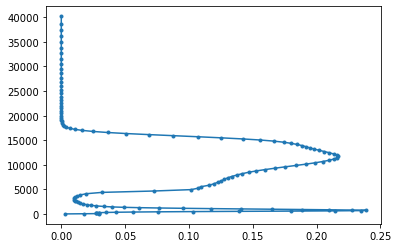

In [34]:
# cltotal = xr.open_dataset(ap.get_file(m,region+"_3D","cltotal"), chunks=chunks_l).cltotal.mean(axis=(0,2))
plt.plot(cl[1:].mean(axis=(0,2)), z, ".-")
plt.show()

In [20]:
del z, iwp_full

In [22]:
z_flat = z_full.flatten()

In [23]:
del z_full

In [24]:
%whos

Variable          Type           Data/Info
------------------------------------------
ProgressBar       type           <class 'dask.diagnostics.progress.ProgressBar'>
ap                module         <module 'utility.analysis<...>/analysis_parameters.py'>
bin_edges         ndarray        26: 26 elems, type `float64`, 208 bytes
bin_mid           ndarray        25: 25 elems, type `float64`, 200 bytes
chunk_dict        dict           n=4
cli               DataArray      <xarray.DataArray 'cli' (<...>    origin:         ms_qi
cm                module         <module 'matplotlib.cm' f<...>ckages/matplotlib/cm.py'>
colors            dict           n=11
dask              module         <module 'dask' from '/sw/<...>ckages/dask/__init__.py'>
i                 int            24
iwp_flat          ndarray        377470080: 377470080 elems, type `float64`, 3019760640 bytes (2879.8681640625 Mb)
iwp_percentiles   ndarray        240x142x142: 4839360 elems, type `float64`, 38714880 bytes (36.921386718

In [ ]:
cli_flat = cli.values.flatten()

[########################################] | 100% Completed | 42.0s


In [ ]:
del cli

In [25]:
hist, x_edges, y_edges, binnum = stats.binned_statistic_2d(iwp_flat, z_flat, cli_flat, 
                          statistic="count", bins=[np.logspace(-7,2,20),np.linspace(0,20000,12)])

NameError: name 'cli_flat' is not defined

In [17]:
hist.shape

(19, 11)

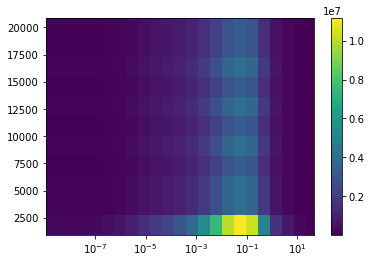

In [18]:
plt.pcolormesh(x_edges[:-1], y_edges[1:], hist.T)
plt.xscale('log')
plt.colorbar()
plt.show()